# Задача
Чем активнее наши пользователи – тем выше нагрузка на сервера. И в последнее время нам всё чаще приходят жалобы, что приложение подвисает. Звучит как задача для девопсов и инженеров!

От вас тоже попросили внести свой вклад в задачу – спрогнозировать, как изменится активность пользователей в течение ближайшего месяца.

1. Выбрать основную метрику, которую мы планируем прогнозировать. Обосновать, почему именно она. Какое временное разрешение вы возьмёте? Будут ли какие-то дополнительные регрессоры, которые вы включите в модель?
2. Построить модель и провалидировать её. Хватает ли у нас данных для бэккастинга с текущей задачей? Если нет, то определить, для какого горизонта прогнозирования у нас хватает данных.
3. Выбрать ту модель, которая кажется вам наиболее удачной. Проинтерпретировать её результаты. Если видите какие-то важные ограничения по выводу – не забудьте их тоже указать.

## Метрика
Для прогноза возьмем метрику DAU , она считает количество уникальных пользователей , как это и отражает нашу проблему. \
Временной промежуток возьмем весь что представлен в нашем датасете с 3 июня. \
Регрессоры в нашей модели использовать не будем. Потому что, чтобы ими воспользоваться нам надо будет предсказывать значения этих регрессоров. Мы хотим сдлеать прогноз на месяц вперед, а у нас есть данные за неполные два месяца. если сначала предсказывать регрессоры, а потом по ним предсказывать DAU, то результат может быть хуже, чем если просто предсказывать DAU.

In [ ]:
!pip install orbit-ml

In [ ]:
!pip install pandahouse

In [3]:
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования прогноза
from orbit.diagnostics.metrics import rmsse
import pandas as pd
import pandahouse as ph
import seaborn as sns

In [4]:
# Выгружаем данные по нашей метрике. Последний день исключаем так за него нет полных данных и он указан не верно (год записан 2123).

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230720',
                      'user':'student',
                      'password':'dpo_python_2020'
                     }

query = '''
SELECT toStartOfDay(toDateTime(date)) AS day,
       unique_users AS dau
FROM
  (select date(time) as date,
          count(distinct user_id) as unique_users
   from simulator_20230720.feed_actions a
   full join simulator_20230720.message_actions b using (user_id)
   group by date(time)) AS virtual_table
GROUP BY day, dau
ORDER BY day
'''

activity = ph.read_clickhouse(query=query, connection=connection)
activity.drop(labels = [68],axis = 0, inplace = True)
activity

,day,dau
0,2023-06-03,878
1,2023-06-04,2238
2,2023-06-05,3105
3,2023-06-06,3721
4,2023-06-07,4617
...,...,...
63,2023-08-05,19554
64,2023-08-06,19572
65,2023-08-07,19768
66,2023-08-08,19363


In [6]:
#зададим рисовательный шаблон для сиборна
sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

<Axes: xlabel='day', ylabel='dau'>

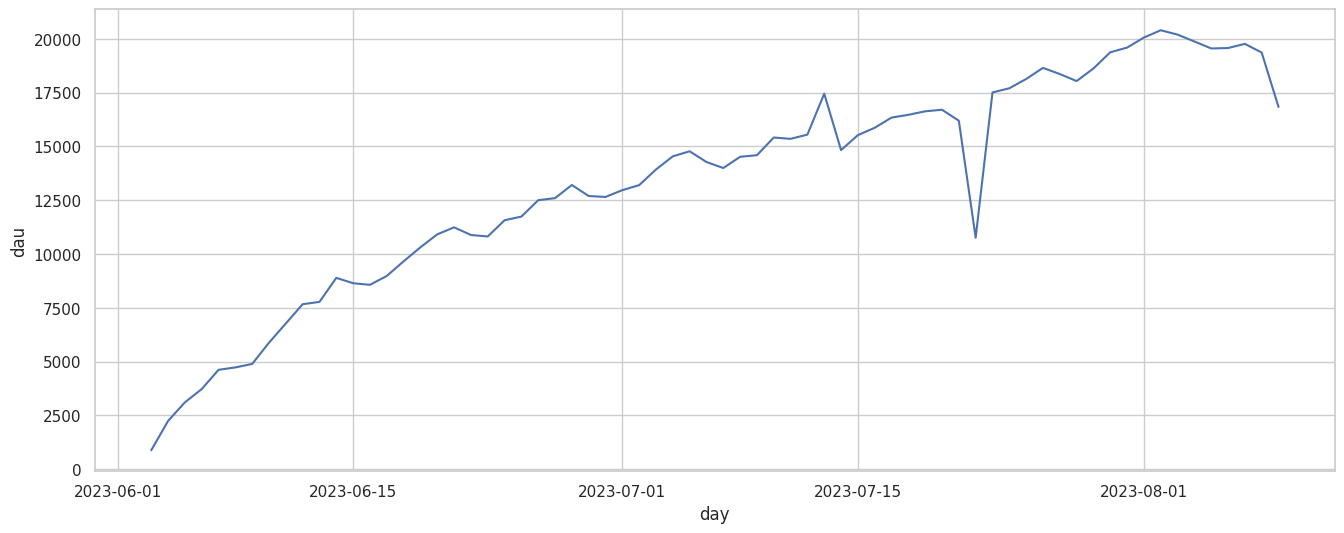

In [7]:
#как менялся DAU
sns.lineplot(x="day", y="dau", data=activity)

## Построение модели

В работе возьмет MAP и MCMC. МСМС самый точный и в долгосрочной перспективе будет полезен, т. к. данных не много, выполняться модель будет не долго. После сравним их, чтобы удостоверится, какая модель лучше \
Для бэккастинга у нас не хватит данных. Есть данные за 2 месяца.
Почему:
1. Данные собирались с низкой частотой (раз в день), объема данных может быть недостаточным.
2. Не стабильность поведения: В эти два месяца был проведен флешмоб. Произошли значительные в активности пользователей (на графике видны скачки), это осложняет прогнозирование на долгий горизонт.

Поэтому разобьем наши данные на тесовую и тренировочную выборки. Тренировочной выборкой будут почти все данные за июнь, а тестовой оставшиеся 30 дней.

In [8]:
train_dat = activity.query("day < '2023-06-30'") #возьмём часть данных для обучения
test_dat = activity.query("day>= '2023-06-30'") ## тестировать будем на 30 днях

2023-08-09 15:12:20 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


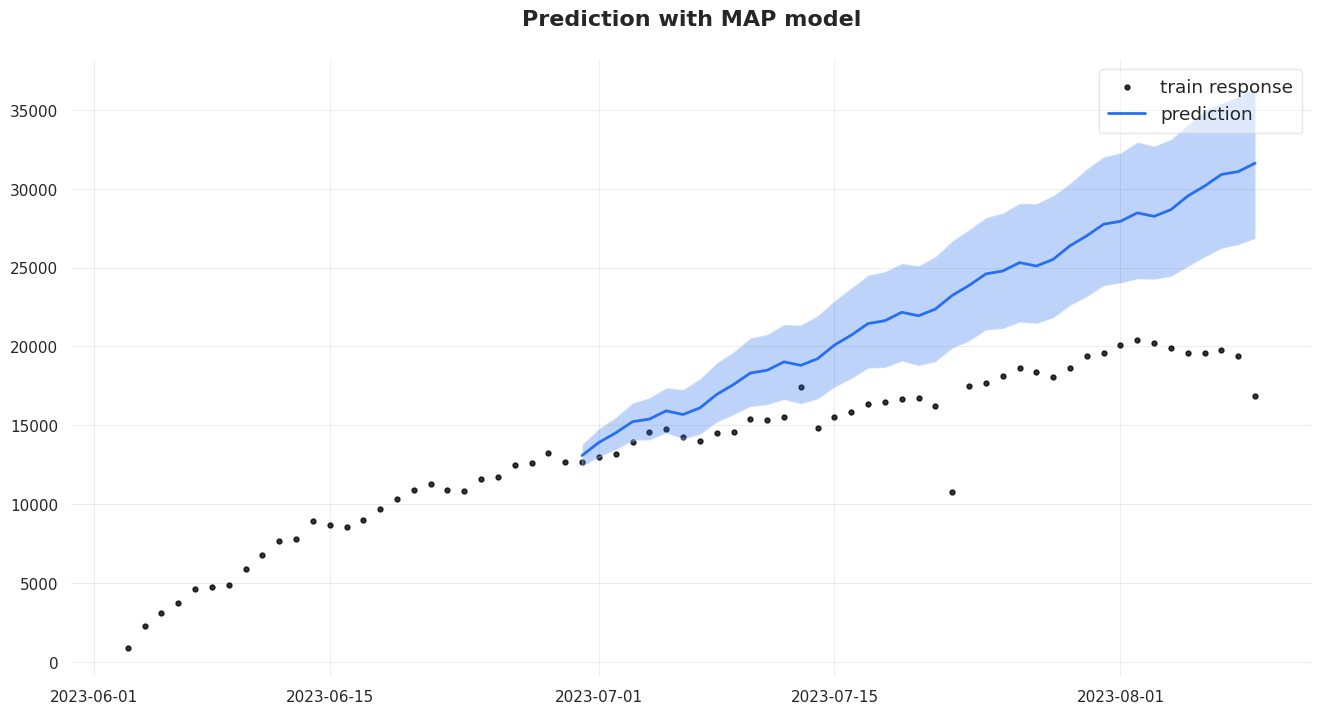

In [10]:
#MAP
map_model = DLT(response_col="dau",
                date_col="day",
                seasonality=7,
                estimator="stan-map",
                n_bootstrap_draws=1000)
map_model.fit(train_dat)
predicted_df_map = map_model.predict(df=test_dat)
_ = plot_predicted_data(activity, predicted_df_map, "day", 'dau', title='Prediction with MAP model')

Seasonality = 7- возьмет из учета количества дней недели, разбивать например, на месяца нет смысла, и данные у нас представлены за каждый день

2023-08-09 15:16:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

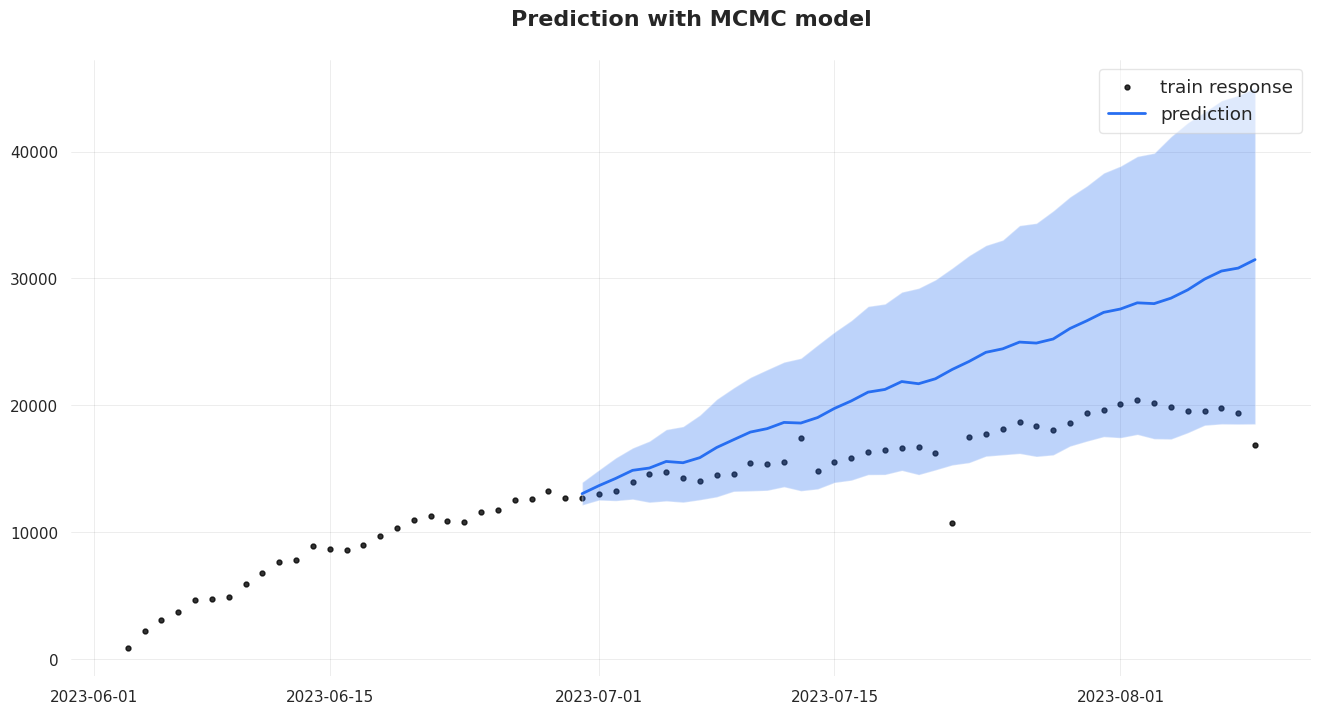

In [13]:
# Строим модель MCMC
mcmc_model= DLT(seasonality=7, response_col="dau", date_col="day",
               estimator='stan-mcmc',
               num_warmup=2000,
               num_sample=1000)

# Обучаем
mcmc_model.fit(train_dat)

# Строим предсказание
predicted_df_mcmc = mcmc_model.predict(df=test_dat)

#Визуализируем
_ = plot_predicted_data(activity, predicted_df_mcmc, "day", 'dau', title='Prediction with MCMC model')

In [14]:
# Сравним модели по RMSSE
print(f"map: {rmsse(test_dat.dau.values, predicted_df_map.prediction.values, train_dat.dau.values)}")
print(f"mcmc: {rmsse(test_dat.dau.values, predicted_df_mcmc.prediction.values, train_dat.dau.values)}")

map: 4.290371071481324
mcmc: 4.120500917488617


В результате мы видим, что модель MCMC лучше предсказывает DAU на период недели, хотя имеет больший доверительный интервал. Это можно увидеть визуально на графиках

## Прогноз

2023-08-09 15:17:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

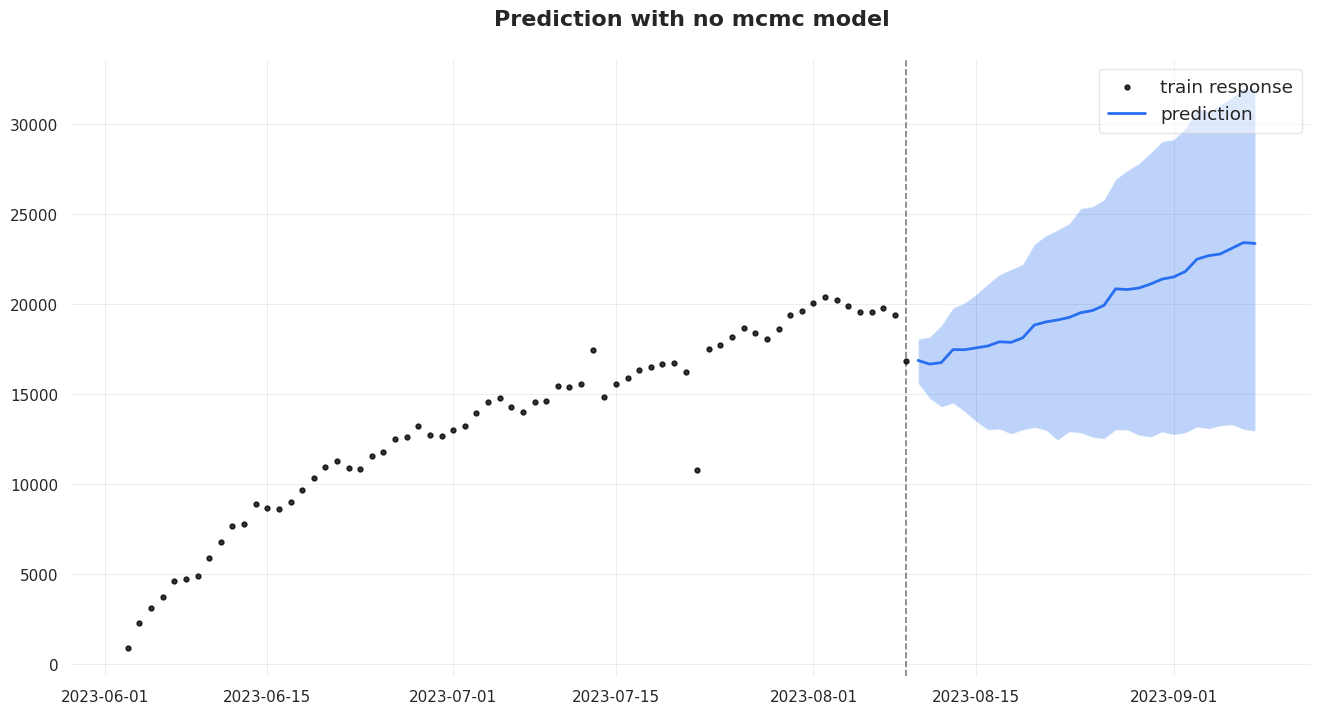

In [15]:
# Обучаем
mcmc_model.fit(activity)

# Строим предсказание
future_df = mcmc_model.make_future_df(periods=30)
predicted_df = mcmc_model.predict(df=future_df)

#Визуализируем
_ = plot_predicted_data(activity, predicted_df, "day", 'dau', title='Prediction with no mcmc model')

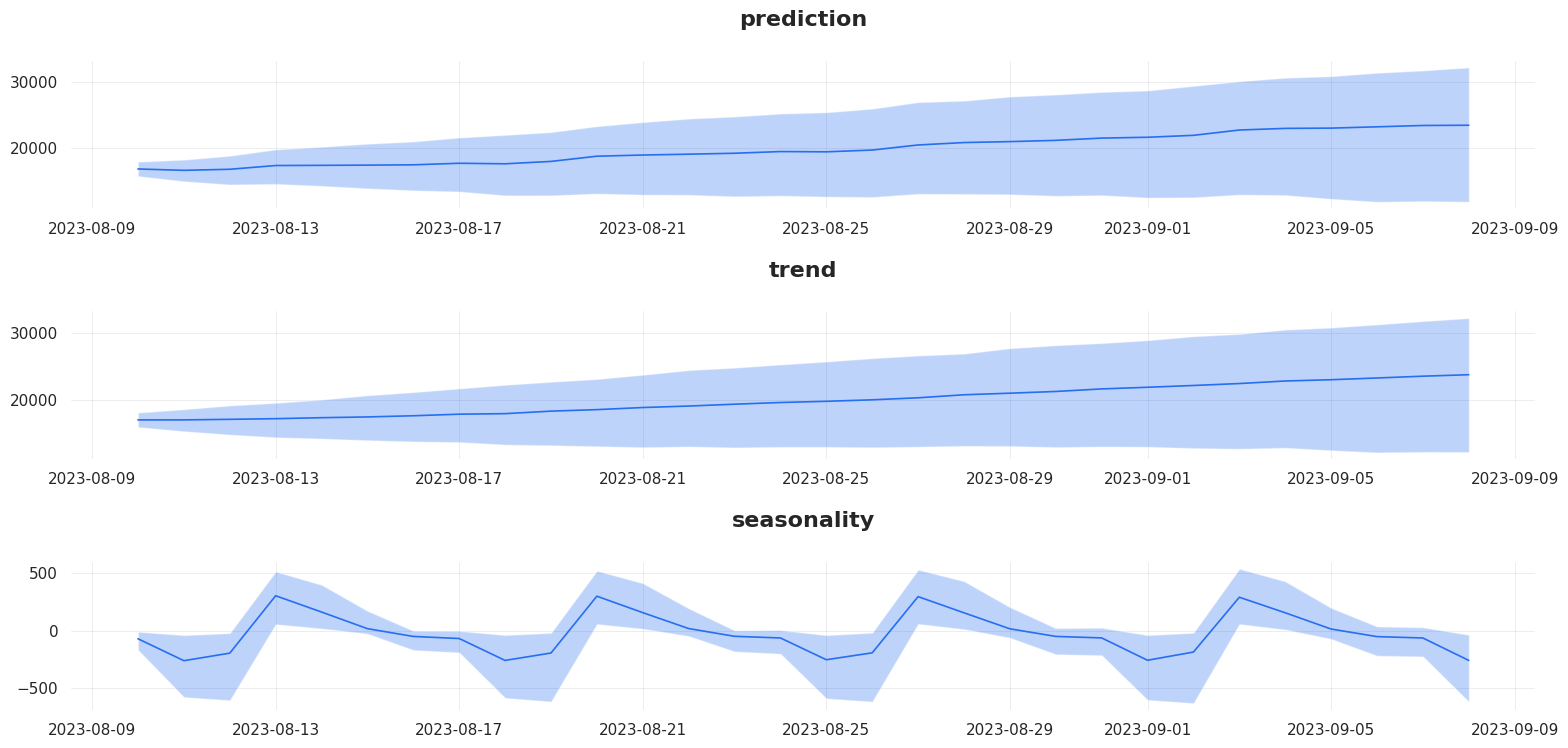

In [16]:
# Декомпозируем
predicted_df = mcmc_model.predict(df=future_df, decompose=True)

_ = plot_predicted_components(predicted_df, "day", plot_components=['prediction', 'trend', 'seasonality'])

## Общий вывод

Да, мы видим положительный рост, нужно будет увеличивать мощность серверов. DAU через месяц вырастит до 24 тыс. пользователей